In [1]:
import albumentations as A
from dataset import SynData, COCO_DETECTION
from copy_paste import InstanceCopyPaste, InstanceRetriever
import random
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon

In [2]:
syn_dataset = SynData("../horse", "../horse")
instance_retriever = InstanceRetriever(syn_dataset)
import albumentations as A

transform = A.Compose([
        A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(512, 512, border_mode=0), #pads with image in the center, not the top left like the paper
        A.RandomCrop(512, 512, p=1),
    ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)

dataset = COCO_DETECTION("../coco2017/val2017", 
                         "../coco2017/annotations/instances_val2017.json", 
                         categories=['horse'], 
                         transform=transform, 
                         instance_copy_paste = InstanceCopyPaste(instance_retriever, 
                                                                 "random", 5, 1, 10))

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [3]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


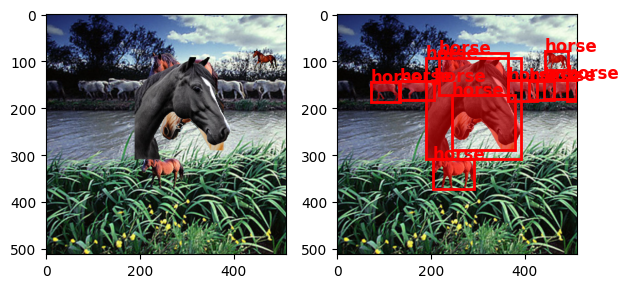

In [7]:
test = dataset[random.randint(0, len(dataset)-1)]

f, ax = plt.subplots(1, 2)
ax[0].imshow(test['image'])
if len(test['bboxes']) == 0:
    pass
else:    
    for i, mask in enumerate(test['masks']):
        color = random_colors(1)[0]
        img = apply_mask(test['image'], mask, color)
        ax[1].imshow(img)
    
        x, y, width, height, _ = test['bboxes'][i][0]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        
        # Add text to the rectangle
        label = f"horse"
        ax[1].text(x, y, label, color='r', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()